In [1]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to reconstruct MR images and how to apply filters 
# in k-space.
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of May 2017
# Author: Christoph Kolbitsch
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'

# import engine module
import pGadgetron as pMR

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt



Using matplotlib backend: TkAgg


In [2]:
#%% GO TO MR FOLDER
os.chdir(pMR.petmr_data_path('mr'))



In [3]:
#%% a definition of a Gaussian function
def gaussian(x, mu, sigma):
    return numpy.exp(-numpy.power(x - mu, 2.) / (2 * numpy.power(sigma, 2.)))
    



In [4]:
#%% GO TO MR FOLDER AND LOAD RAW MR DATA
os.chdir(pMR.petmr_data_path('mr'))
acq_data = pMR.AcquisitionData('simulated_MR_2D_cartesian.h5')




In [5]:
#%% GET SIZE OF K-SPACE DATA
# Get size of current k-space data as tuple
# (number of acquisitions, number of coils, number of samples)
kdim = acq_data.dimensions()
print('Size of k-space %dx%dx%d' % kdim)




Size of k-space 512x8x512


In [6]:
#%% PREPROCESS DATA AND GET SIZE OF K-SPACE DATA
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)

# Get size of k-space data after removal of oversampling
kdim = preprocessed_data.dimensions()
print('Size of k-space %dx%dx%d' % kdim)




Size of k-space 512x8x256


In [7]:
#%% CREATE K-SPACE FILTER
# Set width of Gaussian weighting function
sigma = 5.0

# Create 1D Gaussian weighting function 
gauss_1d = gaussian(numpy.array([numpy.linspace(-kdim[2]/2, kdim[2]/2, kdim[2])]),0,sigma)

# Extend 1D weighting function to 2D by repeating it along the phase encoding 
# dimension
gauss_weight = numpy.tile(gauss_1d, (kdim[0], 1))




In [8]:
#%% APPLY K-SPACE FILTER
# Retrieve k-space data
preprocessed_array = preprocessed_data.as_array()

# Apply 2D weighting function to each coil
for c in range(kdim[1]):
    preprocessed_array[:,c,:] = numpy.multiply(preprocessed_array[:,c,:], gauss_weight)
    
# Update modified k-space data    
preprocessed_data.fill(preprocessed_array)




In [9]:
#%% RECONSTRUCT IMAGES
recon = pMR.FullySampledReconstructor()
recon.set_input(preprocessed_data)
recon.process()




[0, 255, 0, 1]

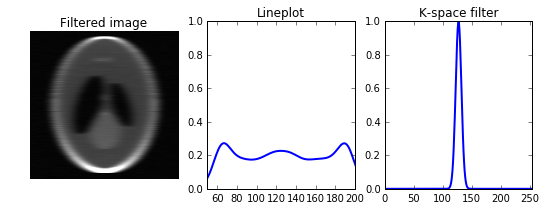

In [10]:
#%% RETRIEVE AND VIEW IMAGE
image_data = recon.get_output()
image_array = abs(image_data.as_array())
image_array = image_array/image_array.max()

fig = plt.figure(num=None, figsize=[9, 3])
plt.set_cmap('gray')
ax = fig.add_subplot(1,3,1)
ax.imshow(image_array[0,:,:], vmin=0, vmax=0.7)
ax.set_title('Filtered image')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.plot(image_array[0,50,:], linewidth=2.0)
ax.set_title('Lineplot')
plt.axis([50, 200, 0, 1])

ax = fig.add_subplot(1,3,3)
ax.plot(gauss_1d[0,:], linewidth=2.0)
ax.set_title('K-space filter')
plt.axis([0, 255, 0, 1])


In [13]:
plt.close('all')